In [1]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive/')

# ディレクトリの移動
%cd /content/drive/My Drive/Colab\ Notebooks/Nishika/japanesePainting

# ディレクトリ内のデータの確認
%ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Nishika/japanesePainting
data/  JapanesePainting_Resnet152.ipynb  model/


デバイス：cuda
         image  gender_status
0  n_00001.jpg              4
1  n_00002.jpg              0
2  n_00003.jpg              0
3  n_00005.jpg              0
4  n_00006.jpg              0
Epoch: 1 / 50
------------------------------------------------------------------
train_loss: 815.3253124618531, train_acc: 0.18389739096164703, train_Micro_f1: 0.33962264150943394
val_loss: 411.92767312791614, val_acc: 0.36217206716537476, val_Micro_f1: 0.3611111111111111
Epoch: 2 / 50
------------------------------------------------------------------
train_loss: 230.62232577323914, train_acc: 0.5449174642562866, train_Micro_f1: 0.6698113207547169
val_loss: 270.6843215094672, val_acc: 0.4852430522441864, val_Micro_f1: 0.5
Epoch: 3 / 50
------------------------------------------------------------------
train_loss: 158.5063383769989, train_acc: 0.6468985676765442, train_Micro_f1: 0.5943396226415094
val_loss: 208.0032123989529, val_acc: 0.5464891791343689, val_Micro_f1: 0.5277777777777778
Epoch: 4 / 50

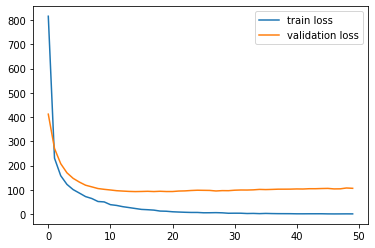

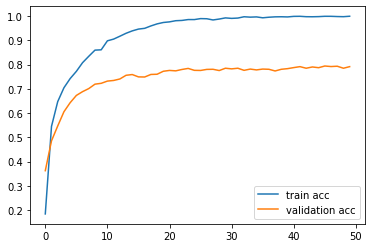

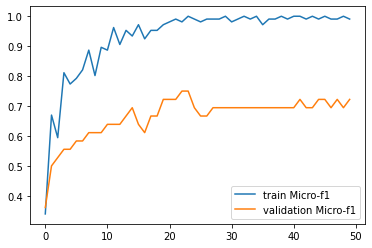

In [6]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch import nn, optim

from collections import defaultdict

'''
定数の指定
'''

# 学習データのラベルマスター
train_master_path = './data/train.csv'

# 画像データのディレクトリ
img_dir = './data/train/' # 画像データのディレクトリ

# リサイズする画像サイズ
photo_size = 128

# バッチサイズ
batch_size= 128

# クラス数の定義
num_classes = 8

# 学習率
lr = 0.0001

# エポック数
epochs = 50

# 保存先のパス
save_path = '/content/drive/My Drive/Colab Notebooks/Nishika/japanesePainting/model/japanesePainting_pytorch_Epoch'

# 学習に使用する機器(device)の設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'デバイス：{device}')

'''
データの読み込み
'''

# ラベルデータの読み込み
train_master = pd.read_csv(train_master_path, sep=',')
print(train_master.head())

# 画像データの名前リストの抽出
image_name_list = train_master['image'].values

# ラベルリストの抽出
label_list = train_master['gender_status'].values

'''
前処理とデータセットの作成
'''

# 学習データと検証データに分割
x_train, x_val, y_train, y_val = train_test_split(image_name_list, label_list, test_size=0.25, random_state=42)

train_transform = transforms.Compose([
    transforms.Resize(photo_size),                    
    transforms.RandomHorizontalFlip(), # ランダムに水平方向に反転させる
    transforms.ColorJitter(), # ランダムに色調を変える
    transforms.RandomRotation(20), # ランダムに画像を回転（引数は±°回転）させる
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                
])

val_transform = transforms.Compose([
    transforms.Resize(photo_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                               
])

# Datasetの設定
class PaintingDataset(Dataset):
    def __init__(self, image_name_list, label_list, img_dir, transform=None):
        self.image_name_list = image_name_list # 画像ファイル名
        self.label_list = label_list # ラベル
        self.img_dir = img_dir # 画像データのディレクトリ
        self.transform = transform

    def __len__(self):
        return len(self.image_name_list) # 1エポックあたりに読み込むデータ数として、入力データの数を指定

    def __getitem__(self, index):
        
        # index番目の画像を読み込み、前処理を行う
        image_path = os.path.join(self.img_dir, self.image_name_list[index]) # train_master.iloc[index, 0]はファイル名を抽出
        img = Image.open(image_path)
        img = self.transform(img)
        
        # index番目のラベルを取得する
        label = self.label_list[index]
        
        return img, label

# データセットの作成
train_dataset = PaintingDataset(x_train, y_train, img_dir, transform=train_transform)
val_dataset = PaintingDataset(x_val, y_val, img_dir, transform=val_transform)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

'''
ネットワークの定義
'''

model = models.mobilenet_v3_large(pretrained=True)
fc_in_features = model.classifier[3].in_features # 最終レイヤー関数の次元数
model.fc = nn.Linear(fc_in_features, num_classes) # 最終レイヤー関数の付け替え

# モデルをGPUに送る
model.to(device)

'''
学習
'''

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
accs = []
f1s = []

val_losses = []
val_accs = []
val_f1s = []

# ベストスコアの初期値
best_loss = np.inf

for epoch in range(epochs):

    # 現在のエポック数の出力
    print(f'Epoch: {epoch+1} / {epochs}')
    print('------------------------------------------------------------------')
    
    '''
    training loop
    '''
    
    # 学習モードの切り替え
    model.train()
    
    running_loss = 0.0
    running_acc = 0.0
    running_f1 = 0.0
    
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device) # 画像データをGPUへ送る
        labels = labels.to(device) # ラベルをGPUへ送る
        
        optimizer.zero_grad() # 勾配の初期化
        
        output = model(imgs) # 予測計算
        
        loss = criterion(output, labels) # 損失計算
        
        loss.backward() # 誤差逆伝播（勾配計算）
        
        running_loss += loss.item() * imgs.size(0) # 損失値を格納
        
        pred = torch.argmax(output, dim=1) # 予測値を出力
        
        running_acc += torch.mean(pred.eq(labels).float()) # 精度を格納
        
        optimizer.step() # 重みの更新（パラメータ修正）
    
    # データロータの大きさで割り、平均値を出す
    running_loss /= len(train_dataloader) # running_lossは足され続けているため割って平均を出す
    running_acc /= len(train_dataloader) # running_accは足され続けているため割って平均を出す
    running_f1 = f1_score(labels.cpu(), pred.cpu(), average='micro')
    
    losses.append(running_loss)
    accs.append(running_acc)
    f1s.append(running_f1)
    
    '''
    validation loop
    '''
    
    # 検証モードの切り替え
    model.eval()
    
    val_running_loss = 0.0
    val_running_acc = 0.0
    val_running_f1 = 0.0
    
    for val_imgs, val_labels in val_dataloader:
        val_imgs = val_imgs.to(device) # 画像データをGPUへ送る
        val_labels = val_labels.to(device) # ラベルをGPUへ送る
        
        val_output = model(val_imgs) # 予測計算
        val_loss = criterion(val_output, val_labels) # 損失計算
        val_running_loss += val_loss.item() * val_imgs.size(0) # 損失値を格納
        
        val_pred = torch.argmax(val_output, dim=1) # 予測値を出力
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()) # 精度を格納
        
    val_running_loss /= len(val_dataloader)
    val_running_acc /= len(val_dataloader)
    val_running_f1 = f1_score(val_labels.cpu(), val_pred.cpu(), average='micro')
    
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    val_f1s.append(val_running_f1)
    
    print(f'train_loss: {running_loss}, train_acc: {running_acc}, train_Micro_f1: {running_f1}')
    print(f'val_loss: {val_running_loss}, val_acc: {val_running_acc}, val_Micro_f1: {val_running_f1}')
     
    # 検証スコアとベストスコアの大小比較を行い、検証スコアが改善した場合のみ以下の処理を行う
    if val_running_loss < best_loss:
        
        # ベストスコアの更新
        best_loss = val_running_loss
        
        # パラメータの名前を指定
        param_name = f'{save_path}{epoch+1}_logloss_{val_running_loss:.4f}.pth'
        
        # パラメータの保存
        torch.save(model.state_dict(), param_name)

'''
学習過程の可視化
'''

# Loss
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

# acc
plt.plot(accs, label='train acc')
plt.plot(val_accs, label='validation acc')
plt.legend()
plt.show()

# Micro-f1
plt.plot(f1s, label='train Micro-f1')
plt.plot(val_f1s, label='validation Micro-f1')
plt.legend()
plt.show()